In [11]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours
import joblib

In [6]:
x = []
y = []
datadir = '../data/train'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)

print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

7600
7600
labels : ['sub', '4', '5', '3', '7', '2', '1', '6', 'mul', '9', '8', '0', 'add', 'div']


Matplotlib library to create a grid of images with corresponding labels.

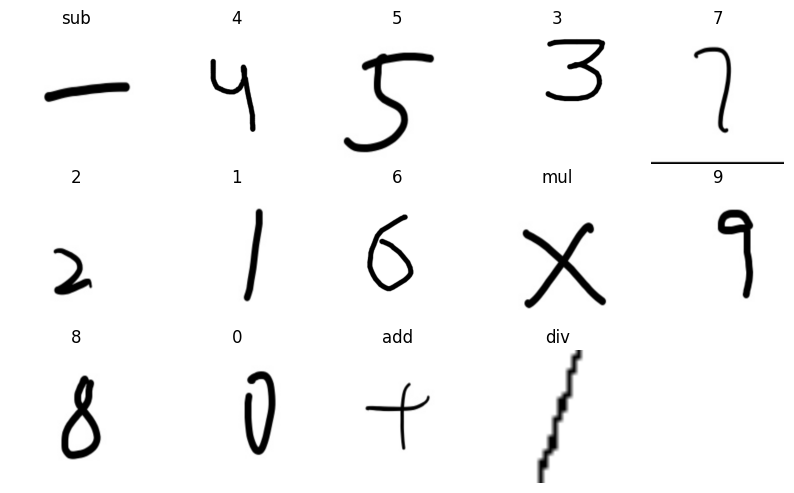

In [7]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

This code uses numpy to find unique categories (unique) and their counts (count). Then, it creates a bar plot using seaborn to visualize the distribution of images across different categories. Finally, it sets a title for the plot and displays it using matplotlib.pyplot.show().

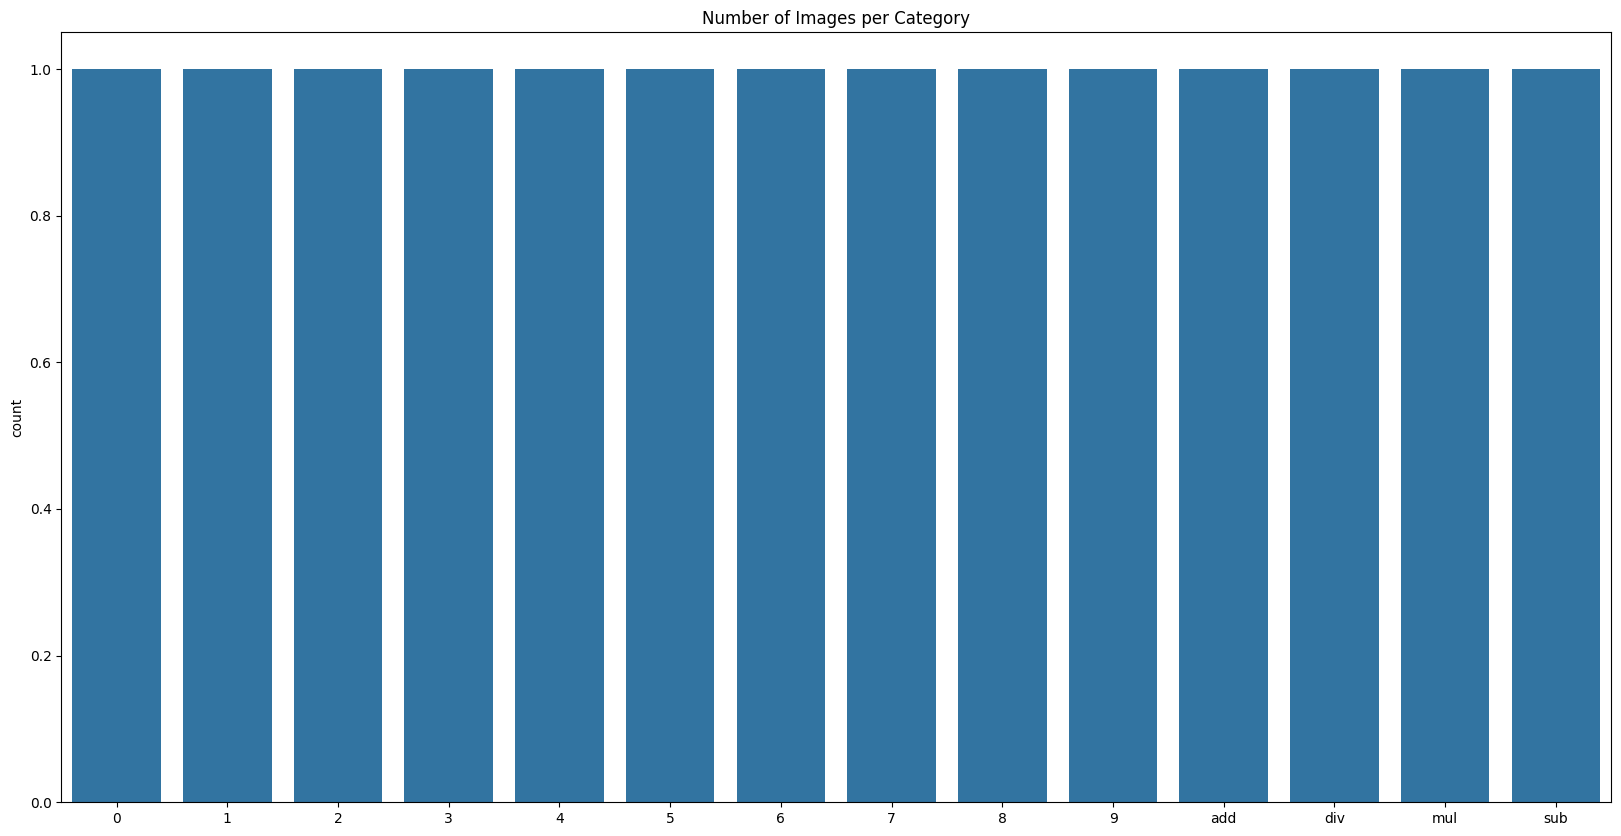

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sns.countplot(x=unique)
plt.title('Number of Images per Category')
plt.show()


This code seems to be preparing a dataset of binary thresholded and resized images for further processing, analysis, or training of a machine learning model. The comments provide a clear explanation of each step in the image processing pipeline.

In [9]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [12]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))
print(f'labels : {list(set(y))}')
joblib.dump(label_encoder, '../models/label_encoder.pkl')

7600
labels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


['label_encoder.pkl']

This code is commonly used in machine learning to create two subsets of the data: one for training a model and another for testing its performance. The training set is used to train the model, and the testing set is used to evaluate how well the model generalizes to new, unseen data. Adjusting the test_size parameter allows you to control the proportion of data used for testing.

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In this code, x corresponds to the categories, and y corresponds to the count for each category. The ax variable is used to set the title with ax.set_title. This should resolve the TypeError you encountered.

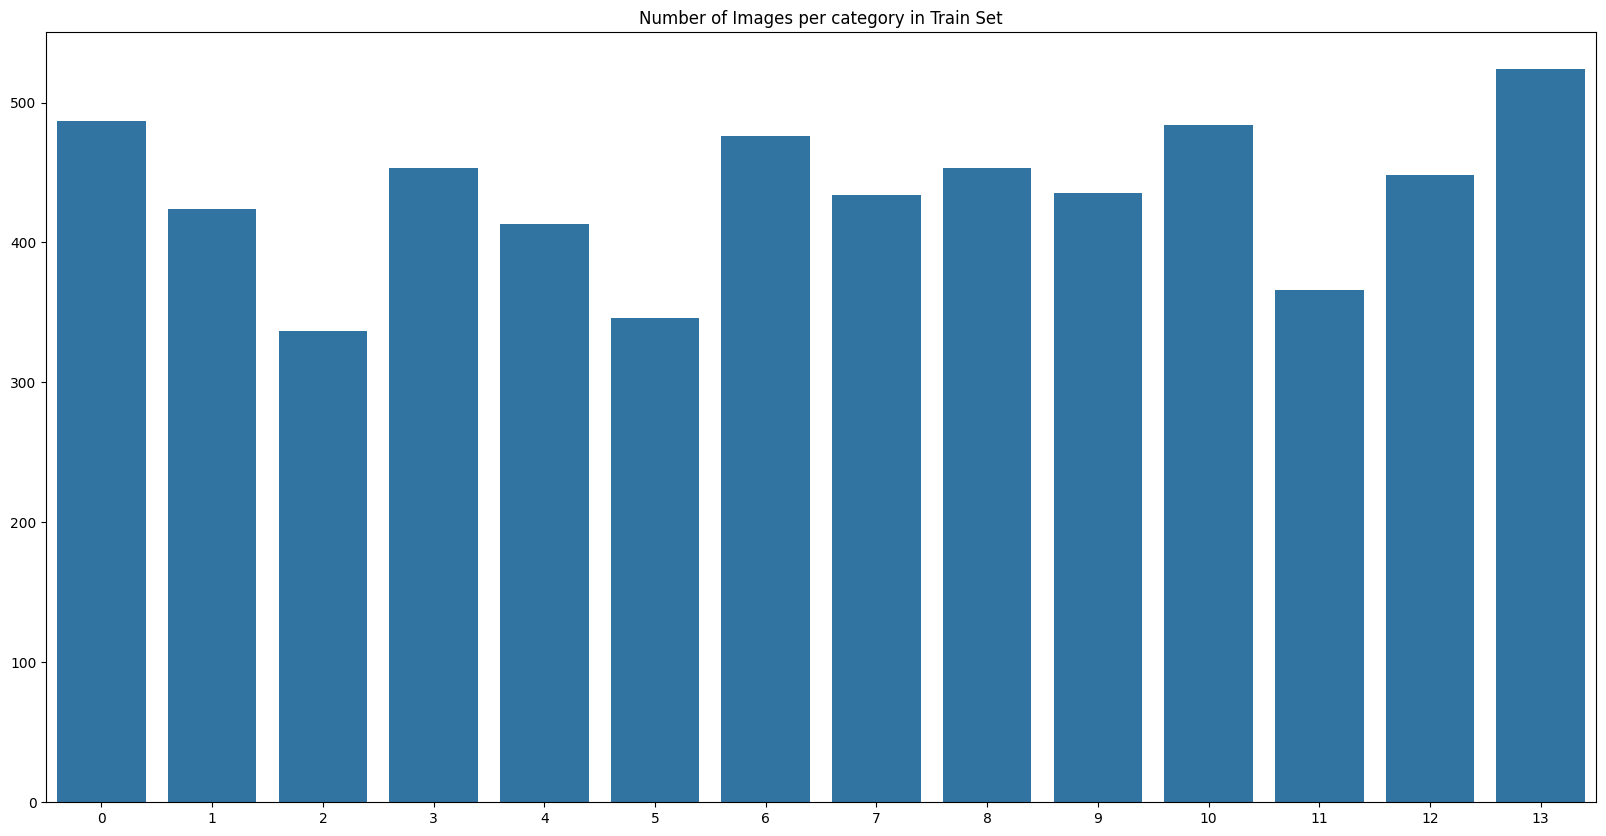

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
ax = sns.barplot(x=unique_train, y=count_train)
ax.set_title('Number of Images per category in Train Set')
plt.show()


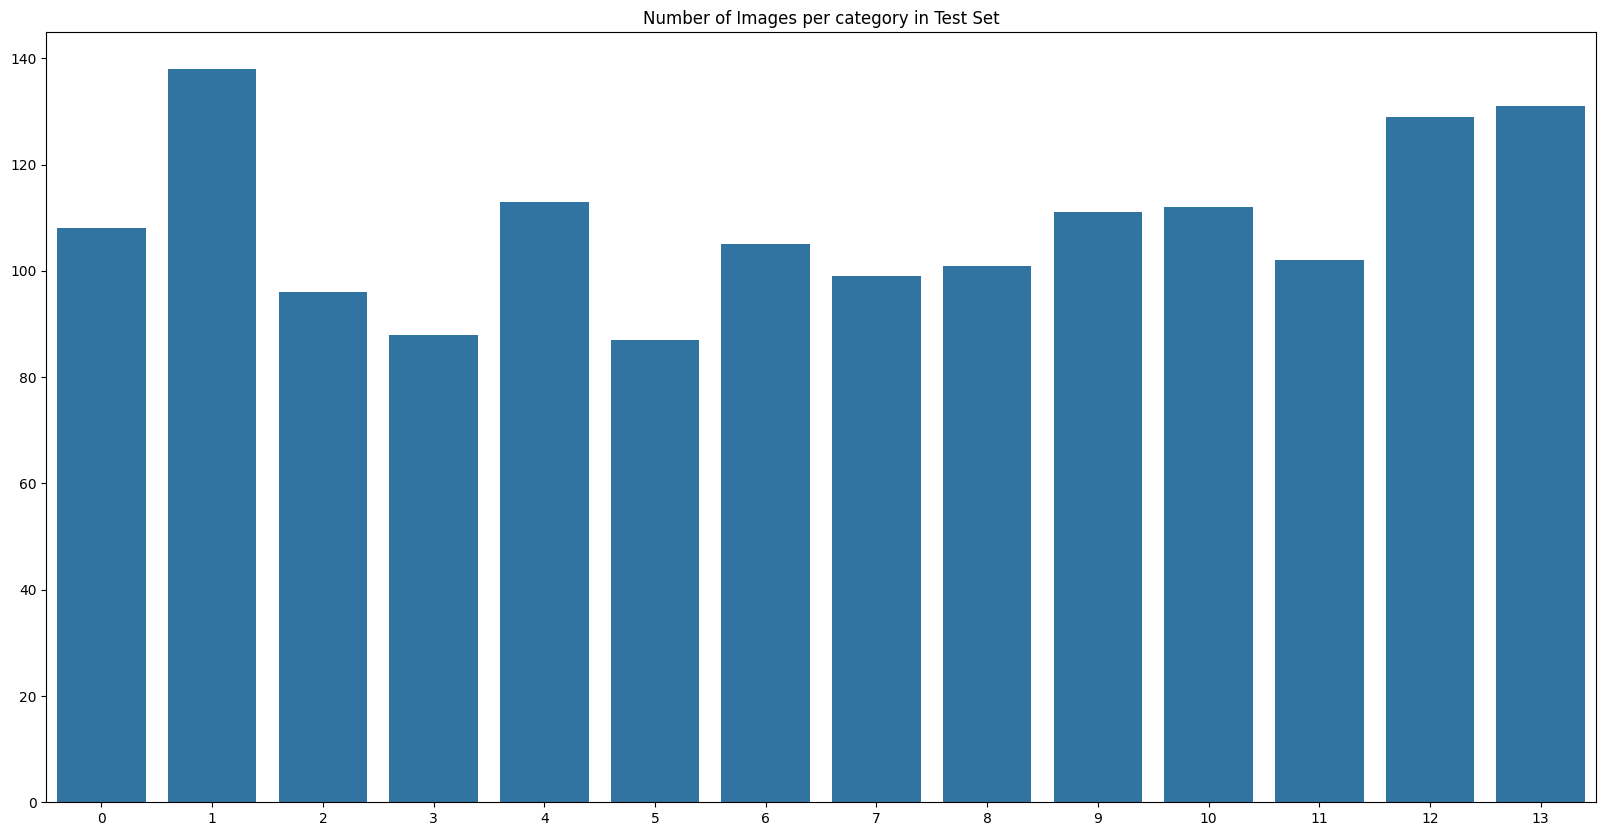

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
ax = sns.barplot(x=unique_test, y=count_test)
ax.set_title('Number of Images per category in Test Set')
plt.show()


In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [17]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [18]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                   

In [19]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.h5',
                             monitor='val_loss', save_best_only=True,
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

This code uses Keras' ImageDataGenerator to perform data augmentation on the training dataset. Data augmentation is a technique used to artificially increase the diversity of the training dataset by applying random transformations to the images, helping the model generalize better to unseen data. The specific augmentations applied here include random zooming and random shifts in both width and height. The augmented data is then used to train the neural network model (model) for 100 epochs, with validation performed on the provided test data. Additionally, there is commented-out code for training a second model (model2) with callbacks, which can be useful for implementing techniques like early stopping during training.

In [21]:
aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))
# hist2 = model2.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/100
48/48 [==============================] - 2s 44ms/step - loss: 2.8040 - accuracy: 0.1988 - val_loss: 2.2374 - val_accuracy: 0.4717
Epoch 2/100
48/48 [==============================] - 2s 42ms/step - loss: 1.7723 - accuracy: 0.5429 - val_loss: 1.5138 - val_accuracy: 0.6454
Epoch 3/100
48/48 [==============================] - 2s 37ms/step - loss: 1.2152 - accuracy: 0.6985 - val_loss: 1.2125 - val_accuracy: 0.7283
Epoch 4/100
48/48 [==============================] - 2s 37ms/step - loss: 0.9524 - accuracy: 0.7704 - val_loss: 1.0569 - val_accuracy: 0.7664
Epoch 5/100
48/48 [==============================] - 2s 39ms/step - loss: 0.8388 - accuracy: 0.7962 - val_loss: 0.8287 - val_accuracy: 0.8289
Epoch 6/100
48/48 [==============================] - 2s 36ms/step - loss: 0.7349 - accuracy: 0.8263 - val_loss: 0.7606 - val_accuracy: 0.8559
Epoch 7/100
48/48 [==============================] - 2s 36ms/step - loss: 0.6493 - accuracy: 0.8495 - val_loss: 0.6678 - val_accuracy: 0.8757
Epoch 

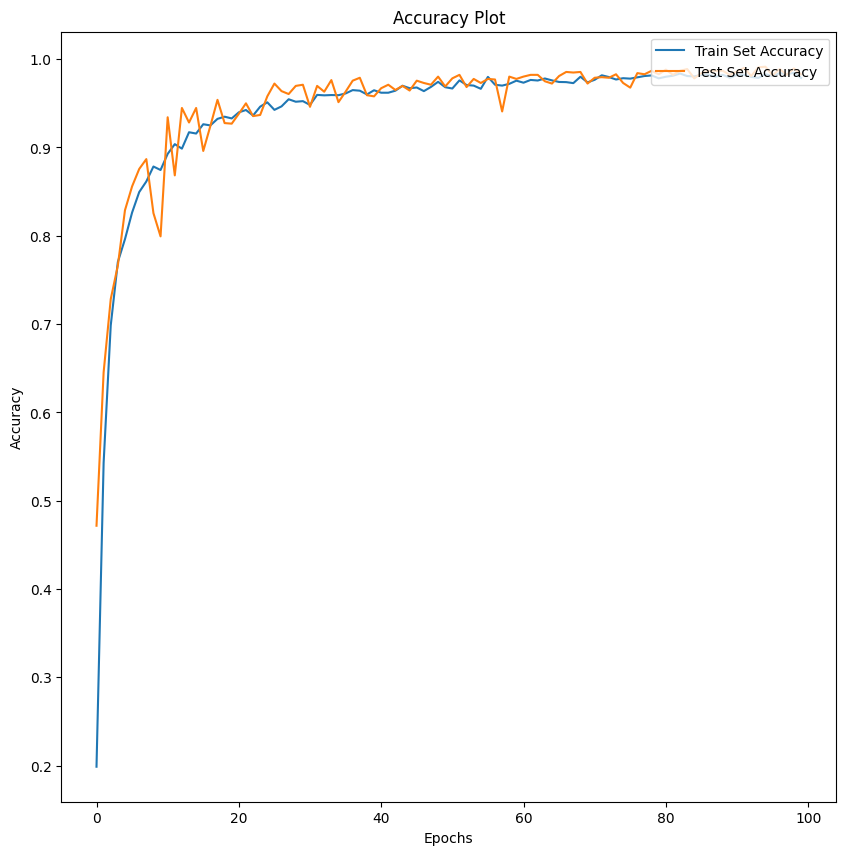

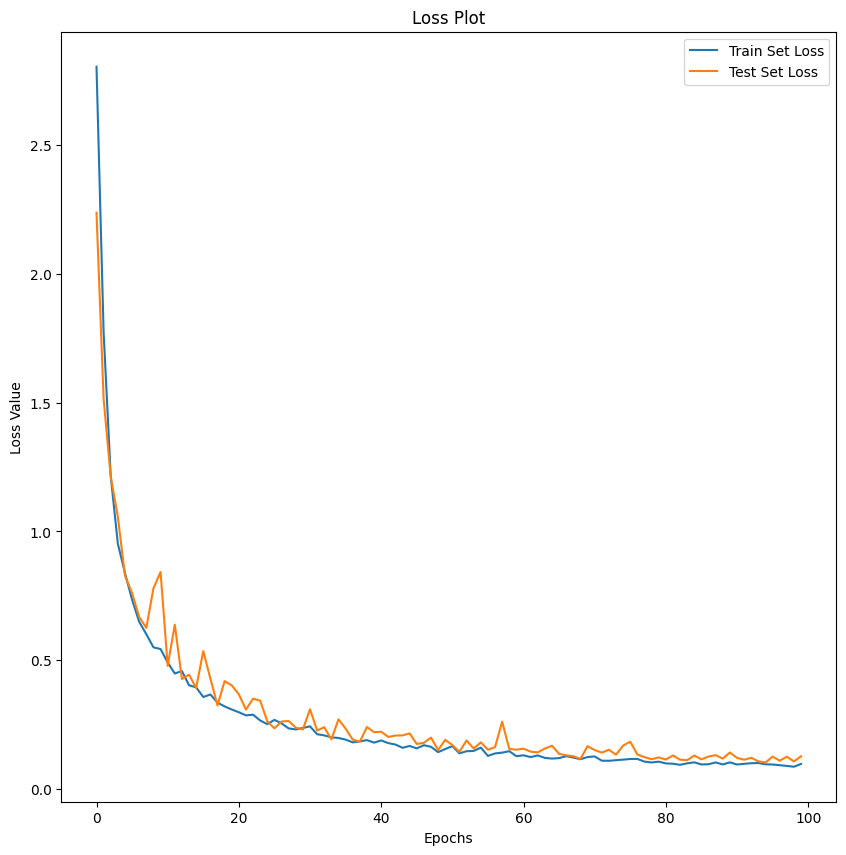

In [22]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

These plots are commonly used in machine learning to visualize the training and validation performance of a model over different epochs. The accuracy plot shows how well the model is performing on the training and test sets, while the loss plot indicates how well the model is minimizing its error during training. The code uses the Matplotlib library to create these plots.

In [23]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

48/48 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       108
           1       1.00      0.95      0.97       138
           2       0.91      0.99      0.95        96
           3       0.98      0.97      0.97        88
           4       0.97      1.00      0.99       113
           5       1.00      0.99      0.99        87
           6       0.95      1.00      0.98       105
           7       0.99      0.96      0.97        99
           8       0.97      0.99      0.98       101
           9       1.00      0.96      0.98       111
          10       0.99      1.00      1.00       112
          11       0.99      1.00      1.00       102
          12       0.99      1.00      1.00       129
          13       1.00      1.00      1.00       131

    accuracy                           0.98      1520
   macro avg       0.98      0.98      0.98      1520
weighted avg       0.98    

In [24]:
model.save('../models/model.h5')

/Users/gisella/Desktop/meth/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
